### Data Exploration

This file is just to play around with one of the batches to get a feel for it. I'll use the events stored in `batch_1_0.parquet` so that it's accessible to others.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import plotly.express as px
import plotly.io as io
import plotly.graph_objs as go

In [2]:
# Settings for graphing

In [3]:
# Uncomment to toggle interactivity of matplotlib plots
%matplotlib notebook

In [4]:
# Load batch_1 train into a DataFrame
batch1 = pd.read_parquet('../batches_train/batch_1_repartitions/part.0.parquet')

In [5]:
batch1.head()

,sensor_id,time,charge,auxiliary
event_id,,,,
24,3918,5928,1.325,True
24,4157,6115,1.175,True
24,3520,6492,0.925,True
24,5041,6665,0.225,True
24,2948,8054,1.575,True


In [6]:
batch1.loc[24]

,sensor_id,time,charge,auxiliary
event_id,,,,
24,3918,5928,1.325,True
24,4157,6115,1.175,True
24,3520,6492,0.925,True
24,5041,6665,0.225,True
24,2948,8054,1.575,True
...,...,...,...,...
24,3452,17812,0.725,True
24,48,18053,0.975,True
24,3267,18095,1.125,True


In [7]:
event_ids = list(set(batch1.index))

In [8]:
# loc is different; returns event_id matching 24
# So here are all pulses from event 24
# for event_id in event_ids:
#     print(batch1.loc[event_id].shape[0])
# Seems like event_ids[3] is a good length (120)
event_ids[3]

786452

In [9]:
sensor_geom = pd.read_csv('../sensor_geometry.csv')
sensor_geom

,sensor_id,x,y,z
0,0,-256.14,-521.08,496.03
1,1,-256.14,-521.08,479.01
2,2,-256.14,-521.08,461.99
3,3,-256.14,-521.08,444.97
4,4,-256.14,-521.08,427.95
...,...,...,...,...
5155,5155,-10.97,6.72,-472.39
5156,5156,-10.97,6.72,-479.39
5157,5157,-10.97,6.72,-486.40
5158,5158,-10.97,6.72,-493.41


<IPython.core.display.Javascript object>


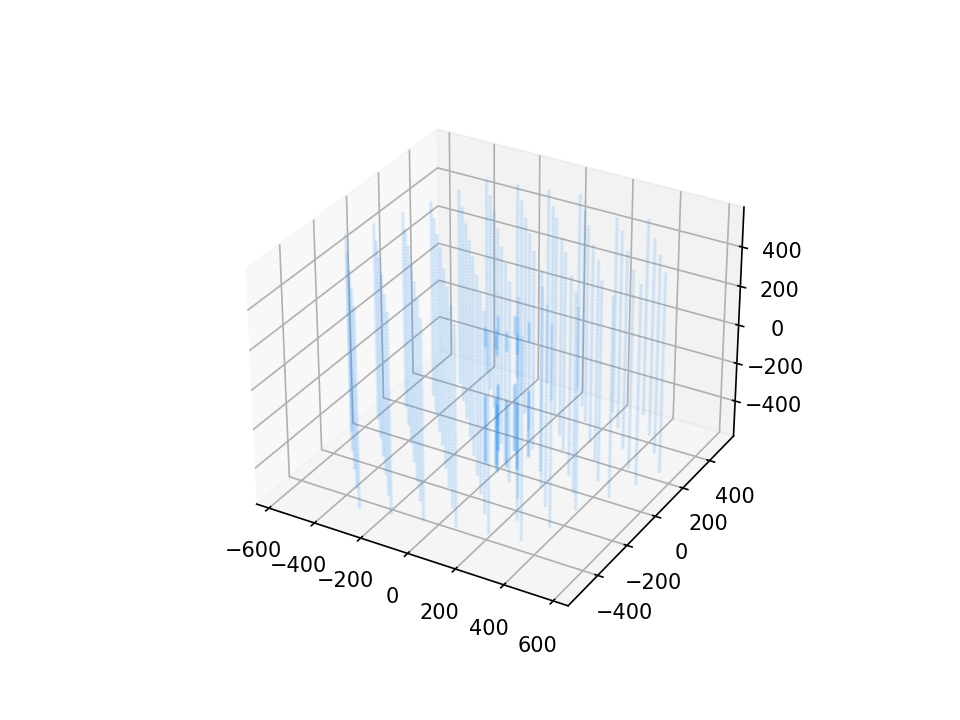

In [10]:
# Plot the sensors
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(sensor_geom.x, sensor_geom.y, sensor_geom.z,
           c='dodgerblue',
           s=1,
           alpha=0.1)

# ax.view_init(30,-115)
# plt.style.use('dark_background')

plt.savefig('sensor_geometry.png',
            format='png')

plt.show()

In [11]:
# Make a function that outputs (x,y,z) for a sensor_id input
def id_to_xyz(sen):
    row = tuple(sensor_geom.loc[sen][1:4])
    return row

In [12]:
# Plot event_id = 786452, we'll leave coloring for later 
event = batch1.loc[786452]

In [13]:
event[event.auxiliary==False].head()

,sensor_id,time,charge,auxiliary
event_id,,,,
786452,1459,9861,0.825,False
786452,1458,10105,0.875,False
786452,4625,13761,0.925,False
786452,4627,14117,0.925,False
786452,4218,14277,1.025,False


<IPython.core.display.Javascript object>


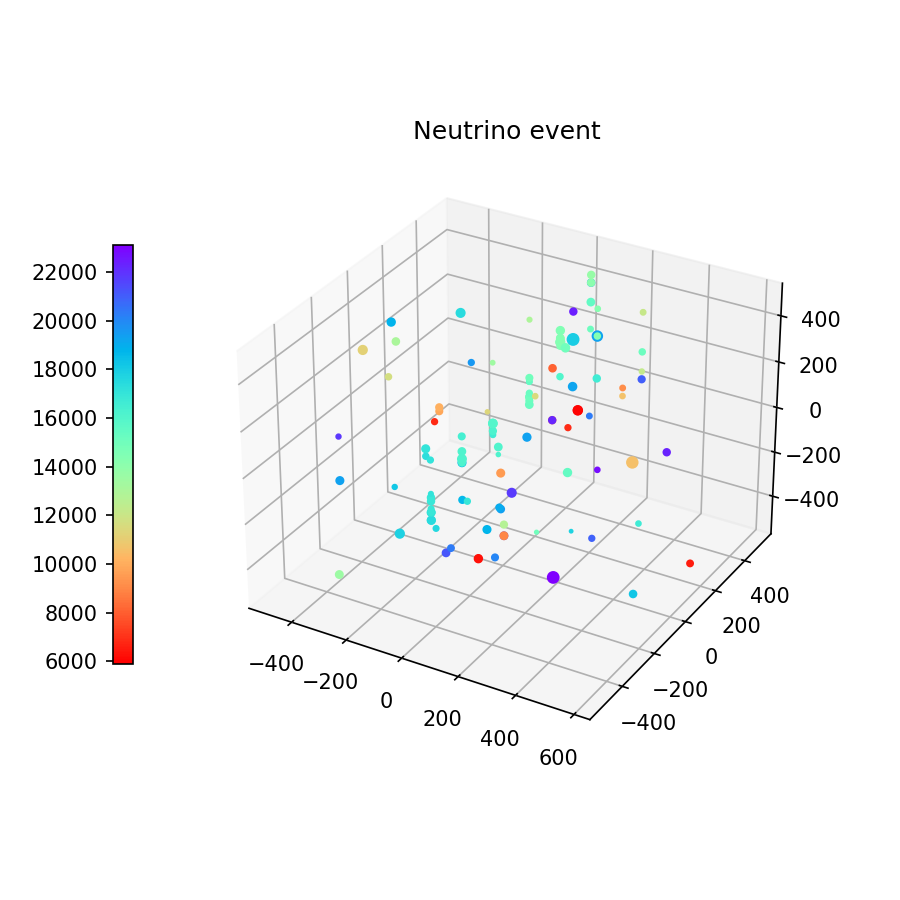

In [14]:
# Plot this event

# Uncomment to toggle interactivity

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(projection='3d')

im = ax.scatter([id_to_xyz(s)[0] for s in event.sensor_id],
           [id_to_xyz(s)[1] for s in event.sensor_id],
           [id_to_xyz(s)[2] for s in event.sensor_id],
           c=event.time,
           cmap='rainbow_r',
           s=10*event.charge,
           alpha=1)

# Color bar
plt.colorbar(im,
             orientation='vertical',
             fraction=0.03,
             location='left')

plt.title("Neutrino event")

# io.write_html(fig, 'test.html')

plt.show()

### Making a function to plot a given event

Various parameters - do we want to show the true direction (for training set), auxiliary pulses plotted or not, etc

In [15]:
# Import the meta data, mainly to include the true direction in plotting
# This cell takes a while (30seconds-ish to 2 mins) to run
# meta = pd.read_parquet('../batches_train/train_meta.parquet/train_meta.parquet')
# meta.head()

In [16]:
def viz_event(eventid, 
              aux_incl=True, 
              show_sensors=False,
              show_true_direction=False,
              save_file=""):
    
    event = batch1.loc[eventid]
    
    # Decide if we're including auxiliary=False or not
    if aux_incl==True:
        xs = [id_to_xyz(s)[0] for s in event.sensor_id]
        ys = [id_to_xyz(s)[1] for s in event.sensor_id]
        zs = [id_to_xyz(s)[2] for s in event.sensor_id]
        times = event.time
        sizes = event.charge
    else:
        event_aux_false = event[event.auxiliary==False]
        xs = [id_to_xyz(s)[0] for s in event_aux_false.sensor_id]
        ys = [id_to_xyz(s)[1] for s in event_aux_false.sensor_id]
        zs = [id_to_xyz(s)[2] for s in event_aux_false.sensor_id]
        times = event_aux_false.time
        sizes = event_aux_false.charge
        
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(projection='3d')

    # This scatter plots the sensor pulses
    im = ax.scatter(xs, ys, zs,
                    c=times,
                    cmap='rainbow_r',
                    s=10*sizes,
                    zorder=2,
                    label='pulse',
                    alpha=1)
    
    # This plots the sensors
    if show_sensors==True:
        ax.scatter(sensor_geom.x, sensor_geom.y, sensor_geom.z,
                   c='0.1',
                   alpha=0.03,
                   s=0.5,
                   zorder=1)
        
    # This plots the true direction
    if show_true_direction==True:
        az = meta[meta.event_id==eventid].azimuth.iloc[0]
        ze = meta[meta.event_id==eventid].zenith.iloc[0]
        xdir_unit = math.cos(az)*math.sin(ze)
        ydir_unit = math.sin(az)*math.sin(ze)
        zdir_unit = math.cos(ze)
        
        scale = 600
        xdir = scale*xdir_unit
        ydir = scale*ydir_unit
        zdir = scale*zdir_unit
        
        
        xs = [0,xdir]
        ys = [0,ydir]
        zs = [0,zdir]
        
        ax.plot(xs, ys, zs,
                '--',
                c='red',
                linewidth=0.75,
                label='true direction of origin',
                zorder=0)

    # Color bar, legend, other niceties
    plt.colorbar(im,
                 orientation='vertical', 
                 label='Nanoseconds passed in event',
                 location='left',
                 fraction=0.02, 
                 pad=0.1)
    
    plt.title("Neutrino event " + str(eventid) + ", aux = " + str(aux_incl),
              fontsize=12)
    plt.legend(loc=(-0.3,0.9))
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_zlabel('$z$')
    
    ax.view_init(30,-45)
    
    ax.grid(False)
    
    # This block turns off axes and gridlines and makes the 
    # background color a nice grey
#     ax.axis('off')
#     ax.patch.set_visible(False)
#     fig.patch.set_facecolor('whitesmoke')
    
    # Saving file, idk how to save interactivity right now

    plt.show()

<IPython.core.display.Javascript object>


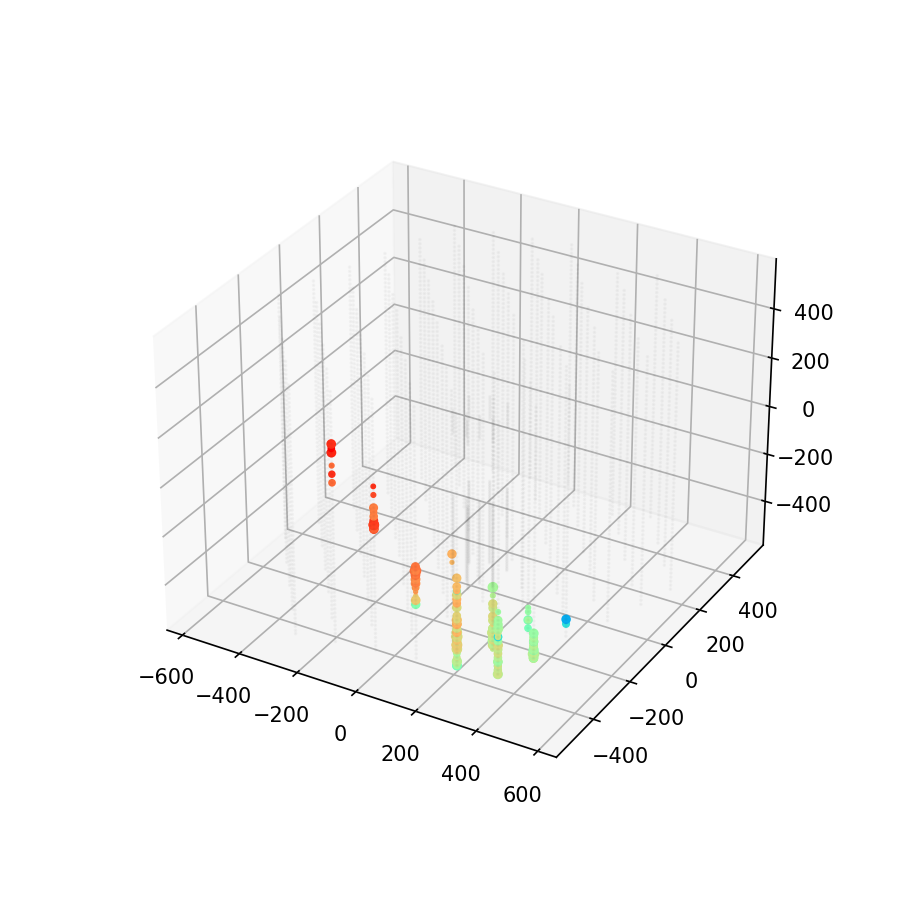

NameError: name 'meta' is not defined

In [17]:
viz_event(event_ids[17], aux_incl=False, show_sensors=True, show_true_direction=True)

### PCA to determine best-fit line from aux = False pulses

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
def find_linear_fit(eventid):
    event = batch1[batch1.auxiliary==False].loc[eventid]
    coords = [id_to_xyz(sen) for sen in event.sensor_id]
    pca = PCA(n_components=1)
    pca.fit(coords)
    dir_cartesian = pca.components_
    x = dir_cartesian[0,0]
    y = dir_cartesian[0,1]
    z = dir_cartesian[0,2]
    d1 = (x,y,z)
    d2 = (-x,-y,-z)
    
    # We need to check if we need d1 or -d1 (=d2)
    first_pulse = np.array(id_to_xyz(event.iloc[0].sensor_id))
    last_pulse = np.array(id_to_xyz(event.iloc[-1].sensor_id))
    
    dir_of_origin = first_pulse - last_pulse
    
    inprod = np.dot(dir_of_origin,np.array(d1))

    if inprod > 0:
        d = d1
    else:
        d = d2
    
    return d

In [ ]:
find_linear_fit(24)

In [ ]:
def viz_and_regress(eventid, 
              aux_incl=True, 
              show_sensors=False,
              show_true_direction=False,
              save_file=""):
    
    event = batch1.loc[eventid]
    
    scale = 600
    
    # Decide if we're including auxiliary=False or not
    if aux_incl==True:
        xs = [id_to_xyz(s)[0] for s in event.sensor_id]
        ys = [id_to_xyz(s)[1] for s in event.sensor_id]
        zs = [id_to_xyz(s)[2] for s in event.sensor_id]
        times = event.time
        sizes = event.charge
    else:
        event_aux_false = event[event.auxiliary==False]
        xs = [id_to_xyz(s)[0] for s in event_aux_false.sensor_id]
        ys = [id_to_xyz(s)[1] for s in event_aux_false.sensor_id]
        zs = [id_to_xyz(s)[2] for s in event_aux_false.sensor_id]
        times = event_aux_false.time
        sizes = event_aux_false.charge
        
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(projection='3d')

    # This scatter plots the sensor pulses
    im = ax.scatter(xs, ys, zs,
                    c=times,
                    cmap='rainbow_r',
                    s=10*sizes,
                    zorder=2,
                    label='pulse',
                    alpha=1)
    
    # This plots the sensors
    if show_sensors==True:
        ax.scatter(sensor_geom.x, sensor_geom.y, sensor_geom.z,
                   c='0.1',
                   alpha=0.03,
                   s=0.5,
                   zorder=1)
        
    # This plots the true direction
    if show_true_direction==True:
        az = meta[meta.event_id==eventid].azimuth.iloc[0]
        ze = meta[meta.event_id==eventid].zenith.iloc[0]
        xdir_unit = math.cos(az)*math.sin(ze)
        ydir_unit = math.sin(az)*math.sin(ze)
        zdir_unit = math.cos(ze)
        
        xdir = scale*xdir_unit
        ydir = scale*ydir_unit
        zdir = scale*zdir_unit
        
        
        xs = [0,xdir]
        ys = [0,ydir]
        zs = [0,zdir]
        
        ax.plot(xs, ys, zs,
                '-.',
                c='red',
                linewidth=0.75,
                label='true direction of origin',
                zorder=0)
        
    # Plots regression
    dir_guess = find_linear_fit(eventid)
    ax.plot([0,scale*dir_guess[0]],
            [0,scale*dir_guess[1]], 
            [0,scale*dir_guess[2]],
            '--',
            linewidth=0.75,
            c='blue',
            label='predicted direction of origin')

    # Color bar, legend, other niceties
    plt.colorbar(im,
                 orientation='vertical', 
                 label='Nanoseconds passed in event',
                 location='left',
                 fraction=0.02, 
                 pad=0.1)
    
    plt.title("Neutrino event " + str(eventid) + ", aux = " + str(aux_incl),
              fontsize=12)
    plt.legend(loc=(-0.3,0.9),
               fontsize=6)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_zlabel('$z$')
    
    ax.view_init(30,-45)
    
    ax.grid(False)
    
    # This block turns off axes and gridlines and makes the 
    # background color a nice grey
#     ax.axis('off')
#     ax.patch.set_visible(False)
#     fig.patch.set_facecolor('whitesmoke')
    
    # Saving file, idk how to save interactivity right now

    plt.show()

In [ ]:
viz_and_regress(event_ids[30], aux_incl=False, show_sensors=True, show_true_direction=True)